# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [1]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 23.07 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

#### Baseline model

In [ ]:
# 0. Imports
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from typing import List, Tuple

In [ ]:
# mean / std computed on a 1-epoch pass over the training set
MEAN = [0.4866, 0.4568, 0.4103]
STD  = [0.2521, 0.2465, 0.2718]

augmented = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

plain = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_ds = OxfordPetDataset('train', transform=augmented)
val_ds   = OxfordPetDataset('val',   transform=plain)
test_ds  = OxfordPetDataset('test',  transform=plain)

train_loader = DataLoader(train_ds, 64, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   64, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  64, shuffle=False, num_workers=4, pin_memory=True)

NUM_CLASSES = train_ds.get_num_classes()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.proj = nn.Identity() if in_ch==out_ch and stride==1 else \
                    nn.Conv2d(in_ch, out_ch, 1, stride, bias=False)

        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )
        self.act = nn.ReLU(inplace=True)

    def forward(self,x):
        return self.act(self.net(x) + self.proj(x))

class MiniXResNet(nn.Module):
    def __init__(self, n_classes=37, drop=0.2):
        super().__init__()
        # stem (depth-wise separable)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),          # groups default to 1
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1),
            nn.Conv2d(32, 64, 1, 1, 0, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        )
        # stages
        self.stage1 = BasicBlock(64, 128, 2)
        self.stage2 = BasicBlock(128, 256, 2)
        self.stage3 = nn.Sequential(
            BasicBlock(256, 256),
            BasicBlock(256, 512, 2)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(drop),
            nn.Linear(512, n_classes)
        )

    def forward(self,x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x)
        return self.head(x)


In [ ]:
def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def run_epoch(model, loader, opt=None):
    train = opt is not None
    model.train(train)
    total_loss, total_acc = 0, 0
    for x,y in loader:
        x,y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        if train:
            opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()*x.size(0)
        total_acc  += accuracy(logits, y)*x.size(0)
    n = len(loader.dataset)
    return total_loss/n, total_acc/n

def fit(model, epochs=15, lr=3e-4):
    model.cuda()
    opt = torch.optim.AdamW(model.parameters(), lr, weight_decay=1e-4)
    best_val, best_state = 0, None
    for ep in range(1,epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, opt)
        val_loss, val_acc = run_epoch(model, val_loader)
        if val_acc > best_val:
            best_val, best_state = val_acc, model.state_dict()
        print(f"ep {ep:02d}: train {tr_acc*100:5.1f} | val {val_acc*100:5.1f}")
    model.load_state_dict(best_state)
    tst_loss, tst_acc = run_epoch(model, test_loader)
    print(f"\nTEST ACCURACY: {tst_acc*100:5.1f} %")
    return best_val, tst_acc


#### Ablation study
- Variant A: no data augmentation

- Variant B: no BatchNorm + Dropout

- Variant C: shallow network

In [ ]:
# Variant A
train_ds.transform = plain

# Variant B
class MiniXResNetNoBN(MiniXResNet):
    def __init__(self,n_classes=37):
        super().__init__(n_classes, drop=0.)
        self.apply(self.remove_bn)
    def remove_bn(self,m):
        if isinstance(m, nn.BatchNorm2d):
            return nn.Identity()
        return m

# Variant C
class MiniXResNetShallow(MiniXResNet):
    def __init__(self,n_classes=37, drop=0.2):
        super().__init__(n_classes,drop)
        self.stage3 = nn.Identity()
        self.head[2] = nn.Linear(256, n_classes)


In [ ]:
results = {}

print("\n==== Baseline ====")
train_ds.transform = augmented
baseline = fit(MiniXResNet())
results["Baseline"] = baseline


==== Baseline ====
ep 01: train   6.6 | val   8.7
ep 02: train  10.5 | val   9.9
ep 03: train  14.3 | val  13.2
ep 04: train  17.9 | val  16.6
ep 05: train  21.5 | val  17.1
ep 06: train  24.6 | val  16.8
ep 07: train  26.9 | val  20.9
ep 08: train  28.6 | val  21.9
ep 09: train  32.1 | val  22.8
ep 10: train  34.8 | val  24.6
ep 11: train  37.5 | val  26.5
ep 12: train  39.6 | val  23.8
ep 13: train  43.4 | val  30.4
ep 14: train  45.5 | val  33.5
ep 15: train  48.4 | val  32.2

TEST ACCURACY:  37.6 %


In [ ]:
print("\n==== Variant A (no augm) ====")
train_ds.transform = plain
var_a = fit(MiniXResNet())
results["No Augmentation"] = var_a


==== Variant A (no augm) ====
ep 01: train   9.6 | val   9.7
ep 02: train  18.0 | val  16.8
ep 03: train  22.3 | val  16.2
ep 04: train  27.6 | val  20.4
ep 05: train  33.1 | val  15.3
ep 06: train  38.4 | val  24.1
ep 07: train  42.0 | val  21.0
ep 08: train  48.1 | val  24.3
ep 09: train  52.0 | val  29.8
ep 10: train  57.2 | val  29.5
ep 11: train  65.2 | val  30.5
ep 12: train  72.8 | val  29.0
ep 13: train  76.0 | val  30.5
ep 14: train  82.3 | val  22.0
ep 15: train  83.3 | val  28.1

TEST ACCURACY:  29.0 %


In [ ]:
print("\n==== Variant B (no BN / no Dropout) ====")
train_ds.transform = augmented
var_b = fit(MiniXResNetNoBN())
results["No BN/Dropout"] = var_b


==== Variant B (no BN / no Dropout) ====
ep 01: train   7.7 | val   9.8
ep 02: train  11.1 | val  11.0
ep 03: train  16.4 | val  14.8
ep 04: train  19.7 | val  16.2
ep 05: train  22.2 | val  18.2
ep 06: train  26.6 | val  20.3
ep 07: train  29.3 | val  15.8
ep 08: train  33.2 | val  25.9
ep 09: train  34.2 | val  20.1
ep 10: train  37.6 | val  25.1
ep 11: train  40.0 | val  24.2
ep 12: train  45.4 | val  24.0
ep 13: train  44.9 | val  26.1
ep 14: train  50.4 | val  31.5
ep 15: train  54.0 | val  31.7

TEST ACCURACY:  34.8 %


In [ ]:
print("\n==== Variant C (shallow) ====")
var_c = fit(MiniXResNetShallow())
results["Shallow"] = var_c


==== Variant C (shallow) ====
ep 01: train   6.6 | val   8.5
ep 02: train  10.2 | val  10.7
ep 03: train  11.9 | val  13.6
ep 04: train  14.0 | val  12.9
ep 05: train  16.1 | val  15.5
ep 06: train  18.7 | val  15.8
ep 07: train  20.3 | val  17.9
ep 08: train  21.6 | val  17.2
ep 09: train  24.2 | val  18.6
ep 10: train  25.2 | val  21.7
ep 11: train  26.4 | val  20.9
ep 12: train  29.2 | val  19.9
ep 13: train  29.2 | val  24.6
ep 14: train  30.7 | val  24.3
ep 15: train  32.5 | val  19.5

TEST ACCURACY:  21.5 %


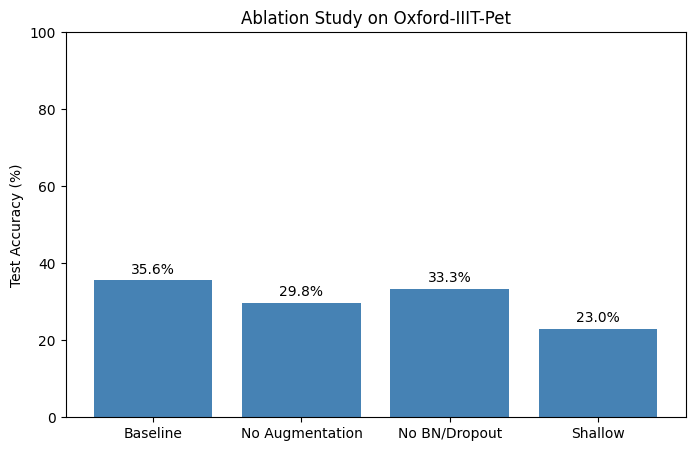

In [ ]:
plt.figure(figsize=(8,5))
accuracies = [np.mean(v)*100 for v in results.values()]  # Convert to percentages
bars = plt.bar(results.keys(), accuracies, color="steelblue")
plt.ylabel("Test Accuracy (%)")
plt.title("Ablation Study on Oxford-IIIT-Pet")

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{bar.get_height():.1f}%", ha="center", va="bottom", fontsize=10)

plt.ylim(0, 100)
plt.show()


We can se how different features of our architecture improve accuracy. Let's try to improve it even more:

- From 15 to 30 epochs
- From fixed learning rate to cosine decay
- Increase augmentation
- More depth in stage 3

In [ ]:
MEAN = [0.4866, 0.4568, 0.4103]
STD  = [0.2521, 0.2465, 0.2718]

augmented = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # PUNTO 4: Random Perspective
    transforms.RandomRotation(degrees=15),                     # PUNTO 4: Rotazione casuale
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

plain = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_ds = OxfordPetDataset('train', augmented)
val_ds   = OxfordPetDataset('val', plain)
test_ds  = OxfordPetDataset('test', plain)

train_loader = DataLoader(train_ds, 64, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   64, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  64, shuffle=False, num_workers=4, pin_memory=True)

NUM_CLASSES = train_ds.get_num_classes()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class MiniXResNet_v2(nn.Module):
    def __init__(self, n_classes=37, drop=0.2):
        super().__init__()

        # STEM: con gruppi depthwise separable
        self.stem = nn.Sequential(
            nn.Conv2d(3, 3, 3, 2, 1, bias=False, groups=3),   # depthwise 3→3
            nn.Conv2d(3, 32, 1, 1, 0, bias=False),            # pointwise 3→32
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2,1),
            nn.Conv2d(32, 64, 1, 1, 0, bias=False),           # aumenta a 64
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        )

        self.stage1 = BasicBlock(64, 128, 2)

        self.stage2 = BasicBlock(128, 256, 2)

        self.stage3 = nn.Sequential(
            BasicBlock(256, 512, 2),
            BasicBlock(512, 512)
        )

        # POOLING + CLASSIFICATORE
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(drop),
            nn.Linear(512, n_classes)
        )

    def forward(self,x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x)
        return self.head(x)


In [ ]:
def run_epoch_v2(model, loader, opt=None):
    model.train(opt is not None)
    total_loss, total_acc = 0, 0
    for x,y in loader:
        x,y = x.cuda(), y.cuda()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        if opt:
            opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * x.size(0)
        total_acc += (logits.argmax(1) == y).float().sum().item()
    return total_loss/len(loader.dataset), total_acc/len(loader.dataset)


def fit_v2(model, epochs=30, lr=3e-4):
    model.cuda()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # add cosine annealing LR scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-6)

    best_val, best_state = 0, None
    history = {'train_acc':[], 'val_acc':[]}
    for ep in range(1, epochs+1):
        _, train_acc = run_epoch_v2(model, train_loader, opt)
        _, val_acc   = run_epoch_v2(model, val_loader)
        scheduler.step()  # aggiorno lr secondo cosine
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        if val_acc > best_val:
            best_val, best_state = val_acc, model.state_dict()
        print(f"Ep{ep:02d} − train {train_acc*100:.1f}% | val {val_acc*100:.1f}% | lr={opt.param_groups[0]['lr']:.2e}")

    model.load_state_dict(best_state)
    _, test_acc = run_epoch_v2(model, test_loader)
    print(f"\n→ TEST ACCURACY finale: {test_acc*100:.1f}%")
    return history, test_acc

In [ ]:
model = MiniXResNet_v2(n_classes=NUM_CLASSES, drop=0.2)
history, test_acc = fit_v2(model, epochs=30)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Ep01 − train 6.6% | val 7.3% | lr=2.99e-04
Ep02 − train 9.6% | val 10.7% | lr=2.97e-04
Ep03 − train 12.2% | val 11.3% | lr=2.93e-04
Ep04 − train 15.3% | val 10.5% | lr=2.87e-04
Ep05 − train 17.7% | val 14.1% | lr=2.80e-04
Ep06 − train 20.1% | val 14.3% | lr=2.71e-04
Ep07 − train 24.2% | val 15.3% | lr=2.62e-04
Ep08 − train 24.9% | val 15.6% | lr=2.51e-04
Ep09 − train 28.7% | val 20.8% | lr=2.38e-04
Ep10 − train 30.6% | val 23.1% | lr=2.25e-04
Ep11 − train 32.9% | val 23.8% | lr=2.11e-04
Ep12 − train 37.4% | val 26.0% | lr=1.97e-04
Ep13 − train 39.9% | val 27.9% | lr=1.82e-04
Ep14 − train 40.7% | val 28.5% | lr=1.66e-04
Ep15 − train 44.6% | val 31.7% | lr=1.50e-04
Ep16 − train 47.2% | val 32.8% | lr=1.35e-04
Ep17 − train 51.0% | val 33.6% | lr=1.19e-04
Ep18 − train 53.9% | val 31.0% | lr=1.04e-04
Ep19 − train 56.1% | val 35.1% | lr=8.97e-05
Ep20 − train 57.9% | val 38.1% | lr=7.58e-05
Ep21 − train 60.0% | val 36.6% | lr=6.26e-05
Ep22 − train 64.6% | val 40.0% | lr=5.05e-05
Ep23 − train 

We can notice great improvement with the last changes, but:
- Increasing train/validation gap (train 73%, val 43%)
- Validation accuracy plateau after the 22nd epoch

Therefore, this is a classic case of overfitting.

Let's try some adjustments:
- dropout from 0.2 to 0.4
- increase augmentation: *transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))*
- t_max and epochs to 50

In [ ]:
MEAN = [0.4866, 0.4568, 0.4103]
STD  = [0.2521, 0.2465, 0.2718]

augmented = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))
])

plain = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_ds = OxfordPetDataset('train', augmented)
val_ds   = OxfordPetDataset('val', plain)
test_ds  = OxfordPetDataset('test', plain)

train_loader = DataLoader(train_ds, 64, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds,   64, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_ds,  64, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

NUM_CLASSES = train_ds.get_num_classes()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model = MiniXResNet_v2(n_classes=NUM_CLASSES, drop=0.4)
history, test_acc = fit_v2(model, epochs=50)

Ep01 − train 6.4% | val 8.8% | lr=3.00e-04
Ep02 − train 8.9% | val 11.6% | lr=2.99e-04
Ep03 − train 12.7% | val 10.0% | lr=2.97e-04
Ep04 − train 14.2% | val 13.8% | lr=2.95e-04
Ep05 − train 16.2% | val 12.9% | lr=2.93e-04
Ep06 − train 19.4% | val 15.4% | lr=2.90e-04
Ep07 − train 21.0% | val 19.9% | lr=2.86e-04
Ep08 − train 24.0% | val 18.3% | lr=2.82e-04
Ep09 − train 27.1% | val 21.6% | lr=2.77e-04
Ep10 − train 28.9% | val 23.7% | lr=2.71e-04
Ep11 − train 32.1% | val 26.8% | lr=2.66e-04
Ep12 − train 34.6% | val 24.5% | lr=2.59e-04
Ep13 − train 36.2% | val 30.0% | lr=2.53e-04
Ep14 − train 39.5% | val 30.0% | lr=2.46e-04
Ep15 − train 41.0% | val 29.0% | lr=2.38e-04
Ep16 − train 43.2% | val 33.2% | lr=2.31e-04
Ep17 − train 47.0% | val 33.0% | lr=2.23e-04
Ep18 − train 48.4% | val 35.8% | lr=2.14e-04
Ep19 − train 50.3% | val 34.9% | lr=2.06e-04
Ep20 − train 52.0% | val 35.2% | lr=1.97e-04
Ep21 − train 54.8% | val 33.6% | lr=1.88e-04
Ep22 − train 58.5% | val 39.3% | lr=1.79e-04
Ep23 − train 

We still have overfitting but accuracy is improved

#### Let's try with complete different architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --------------------------------------------------------
# 1. Squeeze-and-Excitation (SE Block)
# --------------------------------------------------------

class SEBlock(nn.Module):
    def __init__(self, in_ch, r=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_ch, in_ch // r),
            nn.ReLU(inplace=True),
            nn.Linear(in_ch // r, in_ch),
            nn.Sigmoid()
        )

    def forward(self,x):
        b,c,_,_ = x.size()
        s = self.pool(x).view(b,c)
        s = self.fc(s).view(b,c,1,1)
        return x * s

# --------------------------------------------------------
# 2. MBConv block (Mobile Inverted Bottleneck + SE)
# --------------------------------------------------------

class MBConv(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, expand=6):
        super().__init__()
        mid_ch = in_ch * expand
        self.use_residual = (in_ch == out_ch and stride == 1)

        self.expand = nn.Conv2d(in_ch, mid_ch, 1, 1, 0, bias=False)
        self.expand_bn = nn.BatchNorm2d(mid_ch)

        self.depthwise = nn.Conv2d(mid_ch, mid_ch, 3, stride, 1, groups=mid_ch, bias=False)
        self.depthwise_bn = nn.BatchNorm2d(mid_ch)

        self.se = SEBlock(mid_ch)

        self.project = nn.Conv2d(mid_ch, out_ch, 1, 1, 0, bias=False)
        self.project_bn = nn.BatchNorm2d(out_ch)

        self.act = nn.SiLU(inplace=True)  # Swish-like activation

    def forward(self,x):
        out = self.act(self.expand_bn(self.expand(x)))
        out = self.act(self.depthwise_bn(self.depthwise(out)))
        out = self.se(out)
        out = self.project_bn(self.project(out))
        if self.use_residual:
            return out + x
        else:
            return out

# --------------------------------------------------------
# 3. EfficientNet-Mini architecture
# --------------------------------------------------------

class EfficientNetMini(nn.Module):
    def __init__(self, num_classes=37, drop=0.3):
        super().__init__()
        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU(inplace=True),
        )

        # Stages
        self.stage1 = nn.Sequential(
            MBConv(32, 16, stride=1, expand=1),
        )
        self.stage2 = nn.Sequential(
            MBConv(16, 24, stride=2, expand=6),
            MBConv(24, 24, stride=1, expand=6),
        )
        self.stage3 = nn.Sequential(
            MBConv(24, 40, stride=2, expand=6),
            MBConv(40, 40, stride=1, expand=6),
        )
        self.stage4 = nn.Sequential(
            MBConv(40, 80, stride=2, expand=6),
            MBConv(80, 80, stride=1, expand=6),
        )
        self.stage5 = nn.Sequential(
            MBConv(80, 112, stride=1, expand=6),
            MBConv(112, 112, stride=1, expand=6),
        )
        self.stage6 = nn.Sequential(
            MBConv(112, 192, stride=2, expand=6),
            MBConv(192, 192, stride=1, expand=6),
        )

        # Head
        self.head = nn.Sequential(
            nn.Conv2d(192, 320, 1, 1, 0, bias=False),
            nn.BatchNorm2d(320),
            nn.SiLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(drop),
            nn.Linear(320, num_classes)
        )

    def forward(self,x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        return self.head(x)

In [ ]:
model = EfficientNetMini(num_classes=NUM_CLASSES, drop=0.3)
history, test_acc = fit_v2(model, epochs=50, lr=1e-3)

Ep01 − train 4.7% | val 5.0% | lr=9.99e-04
Ep02 − train 9.0% | val 9.0% | lr=9.96e-04
Ep03 − train 10.3% | val 9.9% | lr=9.91e-04
Ep04 − train 14.3% | val 12.5% | lr=9.84e-04
Ep05 − train 15.6% | val 12.8% | lr=9.76e-04
Ep06 − train 18.8% | val 16.4% | lr=9.65e-04
Ep07 − train 23.2% | val 21.9% | lr=9.52e-04
Ep08 − train 24.7% | val 22.8% | lr=9.38e-04
Ep09 − train 28.6% | val 26.1% | lr=9.22e-04
Ep10 − train 30.9% | val 22.6% | lr=9.05e-04
Ep11 − train 34.0% | val 28.8% | lr=8.85e-04
Ep12 − train 37.6% | val 30.6% | lr=8.65e-04
Ep13 − train 39.6% | val 34.6% | lr=8.42e-04
Ep14 − train 40.8% | val 31.9% | lr=8.19e-04
Ep15 − train 45.7% | val 37.4% | lr=7.94e-04
Ep16 − train 49.4% | val 37.0% | lr=7.68e-04
Ep17 − train 51.6% | val 42.1% | lr=7.41e-04
Ep18 − train 52.9% | val 41.7% | lr=7.13e-04
Ep19 − train 55.5% | val 46.3% | lr=6.84e-04
Ep20 − train 57.3% | val 44.4% | lr=6.55e-04
Ep21 − train 58.9% | val 47.2% | lr=6.25e-04
Ep22 − train 59.9% | val 47.5% | lr=5.94e-04
Ep23 − train 64

### Conlusions

Compared to the previous architecture, the proposed EfficientNetMini model achieved higher overall accuracy while simultaneously reducing the performance gap between training and validation. This indicates better generalization and a more robust learning process, supported by architectural improvements such as SE blocks and MBConv layers combined with advanced data augmentation and learning rate scheduling. These design choices contributed to a more stable and consistent training trajectory on the Oxford-IIIT-Pet dataset. However, there is still room for improvement through additional techniques such as stronger regularization, advanced augmentation (e.g., MixUp or CutMix), and class balancing strategies, which could further enhance the model’s generalization capabilities.

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

### 2A

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
MEAN = [0.4866, 0.4568, 0.4103]
STD  = [0.2521, 0.2465, 0.2718]

augmented = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))
])

plain = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_ds = OxfordPetDataset('train', augmented)
val_ds   = OxfordPetDataset('val', plain)
test_ds  = OxfordPetDataset('test', plain)

train_loader = DataLoader(train_ds, 64, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds,   64, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_ds,  64, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

NUM_CLASSES = train_ds.get_num_classes()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def run_epoch_v2(model, loader, opt=None):
    model.train(opt is not None)
    total_loss, total_acc = 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total_loss += loss.item() * x.size(0)
        total_acc  += (logits.argmax(1) == y).float().sum().item()
    return total_loss/len(loader.dataset), total_acc/len(loader.dataset)

def fit_v2(model, epochs=50, lr=1e-3):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-6)

    best_val, best_state = 0, None
    history = {'train_acc':[], 'val_acc':[]}

    for ep in range(1, epochs+1):
        train_loss, train_acc = run_epoch_v2(model, train_loader, opt)
        val_loss, val_acc     = run_epoch_v2(model, val_loader)
        scheduler.step()

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if val_acc > best_val:
            best_val, best_state = val_acc, model.state_dict()

        print(f"Ep{ep:02d} − train {train_acc*100:.1f}% | val {val_acc*100:.1f}% | lr={opt.param_groups[0]['lr']:.2e}")

    model.load_state_dict(best_state)
    _, test_acc = run_epoch_v2(model, test_loader)
    print(f"\n→ TEST ACCURACY finale: {test_acc*100:.1f}%")

    return history, test_acc

In [ ]:
# modello
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

# avvio training
history, test_acc = fit_v2(model, epochs=50, lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


Ep01 − train 55.5% | val 35.8% | lr=9.99e-04
Ep02 − train 70.6% | val 54.5% | lr=9.96e-04
Ep03 − train 76.2% | val 69.2% | lr=9.91e-04
Ep04 − train 80.0% | val 64.2% | lr=9.84e-04
Ep05 − train 81.3% | val 63.7% | lr=9.76e-04
Ep06 − train 84.5% | val 69.0% | lr=9.65e-04
Ep07 − train 84.7% | val 64.7% | lr=9.52e-04
Ep08 − train 85.9% | val 63.8% | lr=9.38e-04
Ep09 − train 87.8% | val 64.0% | lr=9.22e-04
Ep10 − train 89.0% | val 67.1% | lr=9.05e-04
Ep11 − train 90.7% | val 70.6% | lr=8.85e-04
Ep12 − train 91.1% | val 72.0% | lr=8.65e-04
Ep13 − train 91.5% | val 72.1% | lr=8.42e-04
Ep14 − train 91.8% | val 69.6% | lr=8.19e-04
Ep15 − train 93.0% | val 71.6% | lr=7.94e-04
Ep16 − train 94.5% | val 73.0% | lr=7.68e-04
Ep17 − train 95.4% | val 75.1% | lr=7.41e-04
Ep18 − train 94.7% | val 69.8% | lr=7.13e-04
Ep19 − train 95.0% | val 71.9% | lr=6.84e-04
Ep20 − train 96.1% | val 70.6% | lr=6.55e-04
Ep21 − train 96.7% | val 76.1% | lr=6.25e-04
Ep22 − train 97.3% | val 74.3% | lr=5.94e-04
Ep23 − tra

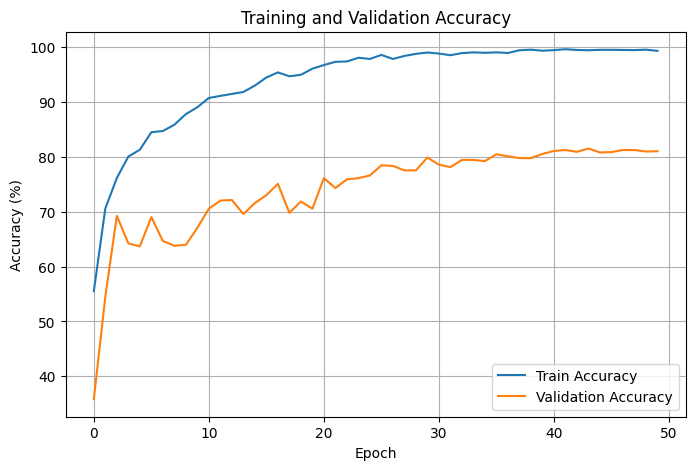

In [ ]:
plt.figure(figsize=(8,5))
plt.plot([x*100 for x in history['train_acc']], label="Train Accuracy")
plt.plot([x*100 for x in history['val_acc']], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

### Conclusions

- Training accuracy is nearly saturated at 99%

- Validation accuracy peaks around 81% and then plateaus

There's a significant gap between training and validation (almost 20%) which is a classic sign of overfitting.
So the main priority now is improving generalization (not the ability to fit the training data).

### 2B

In order to reduce overfitting we can:
- Increase weight decay
- label smoothing
- Increase data augmentation: RandomErasing p=0.4 and ColorJitter to 0.3
- AdamW lr=5e-4

Furthermore, we decided to add early stopping because after 30 epochs we notice that there isn't any improvements in accuracy.

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
MEAN = [0.4866, 0.4568, 0.4103]
STD  = [0.2521, 0.2465, 0.2718]

augmented = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),  # aggiunto
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.4, scale=(0.02, 0.2))  # aumentato a p=0.4
])

plain = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_ds = OxfordPetDataset('train', augmented)
val_ds   = OxfordPetDataset('val', plain)
test_ds  = OxfordPetDataset('test', plain)

train_loader = DataLoader(train_ds, 64, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds,   64, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_ds,  64, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

NUM_CLASSES = train_ds.get_num_classes()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def run_epoch_v2(model, loader, opt=None):
    model.train(opt is not None)
    total_loss, total_acc = 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y, label_smoothing=0.1)  # added label smoothing
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total_loss += loss.item() * x.size(0)
        total_acc  += (logits.argmax(1) == y).float().sum().item()
    return total_loss/len(loader.dataset), total_acc/len(loader.dataset)

# added early stopping and T_max increased
def fit_v2(model, epochs=50, lr=1e-3, weight_decay=5e-4, patience=10):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs*2, eta_min=1e-6)

    best_val, best_state = 0, None
    history = {'train_acc':[], 'val_acc':[]}
    wait = 0

    for ep in range(1, epochs+1):
        train_loss, train_acc = run_epoch_v2(model, train_loader, opt)
        val_loss, val_acc     = run_epoch_v2(model, val_loader)
        scheduler.step()

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if val_acc > best_val:
            best_val, best_state = val_acc, model.state_dict()
            wait = 0
        else:
            wait += 1

        print(f"Ep{ep:02d} − train {train_acc*100:.1f}% | val {val_acc*100:.1f}% | lr={opt.param_groups[0]['lr']:.2e}")

        if wait >= patience:
            print(f"\n→ Early stopping attivato dopo {ep} epoche (no miglioramento su val acc per {patience})")
            break

    model.load_state_dict(best_state)
    _, test_acc = run_epoch_v2(model, test_loader)
    print(f"\n→ TEST ACCURACY finale: {test_acc*100:.1f}%")

    return history, test_acc


In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

history, test_acc = fit_v2(model, epochs=50, lr=5e-4)

Ep01 − train 58.8% | val 65.1% | lr=5.00e-04
Ep02 − train 79.4% | val 68.9% | lr=5.00e-04
Ep03 − train 84.1% | val 70.9% | lr=4.99e-04
Ep04 − train 85.3% | val 68.6% | lr=4.98e-04
Ep05 − train 88.8% | val 74.2% | lr=4.97e-04
Ep06 − train 90.2% | val 71.2% | lr=4.96e-04
Ep07 − train 90.0% | val 70.2% | lr=4.94e-04
Ep08 − train 92.8% | val 73.4% | lr=4.92e-04
Ep09 − train 92.9% | val 77.7% | lr=4.90e-04
Ep10 − train 94.8% | val 75.3% | lr=4.88e-04
Ep11 − train 94.1% | val 77.4% | lr=4.85e-04
Ep12 − train 95.1% | val 74.8% | lr=4.82e-04
Ep13 − train 94.8% | val 77.6% | lr=4.79e-04
Ep14 − train 96.2% | val 75.5% | lr=4.76e-04
Ep15 − train 96.4% | val 77.9% | lr=4.73e-04
Ep16 − train 96.6% | val 78.0% | lr=4.69e-04
Ep17 − train 97.2% | val 77.9% | lr=4.65e-04
Ep18 − train 96.8% | val 77.1% | lr=4.61e-04
Ep19 − train 97.0% | val 77.5% | lr=4.57e-04
Ep20 − train 97.2% | val 81.5% | lr=4.52e-04
Ep21 − train 97.4% | val 76.8% | lr=4.48e-04
Ep22 − train 97.7% | val 77.7% | lr=4.43e-04
Ep23 − tra

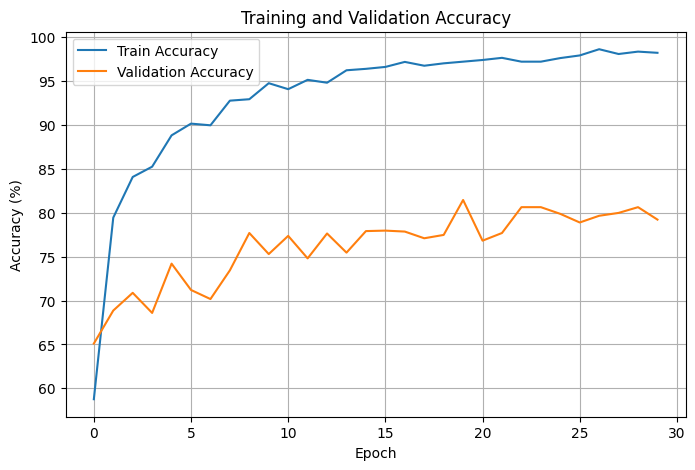

In [ ]:
plt.figure(figsize=(8,5))
plt.plot([x*100 for x in history['train_acc']], label="Train Accuracy")
plt.plot([x*100 for x in history['val_acc']], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

The latest changes haven't led to any meaningful improvements. Let's try with Mixup and CutMix techniques for regularization.

Mixup (Zhang et al., 2017) and CutMix (Yun et al., 2019) are data augmentation techniques designed to improve model generalization, especially in datasets with high variability. These methods create new training samples by combining existing ones, encouraging the model to learn smoother decision boundaries. In practice, they have been shown to be effective in reducing overfitting.



In [5]:
MEAN = [0.4866, 0.4568, 0.4103]
STD  = [0.2521, 0.2465, 0.2718]

augmented = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),  # aggiunto
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.4, scale=(0.02, 0.2))  # aumentato a p=0.4
])

plain = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_ds = OxfordPetDataset('train', augmented)
val_ds   = OxfordPetDataset('val', plain)
test_ds  = OxfordPetDataset('test', plain)

train_loader = DataLoader(train_ds, 64, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds,   64, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_ds,  64, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

NUM_CLASSES = train_ds.get_num_classes()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    '''Returns cutmix inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size, _, h, w = x.size()
    index = torch.randperm(batch_size).to(x.device)

    cx = np.random.randint(w)
    cy = np.random.randint(h)
    cut_w = int(w * np.sqrt(1 - lam))
    cut_h = int(h * np.sqrt(1 - lam))

    x1 = np.clip(cx - cut_w // 2, 0, w)
    x2 = np.clip(cx + cut_w // 2, 0, w)
    y1 = np.clip(cy - cut_h // 2, 0, h)
    y2 = np.clip(cy + cut_h // 2, 0, h)

    x[:,:,y1:y2,x1:x2] = x[index,:,y1:y2,x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (w * h))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam


In [7]:
def run_epoch_v2(model, loader, opt=None, mixup_cutmix_alpha=1.0, mixup_cutmix_prob=0.15):
    model.train(opt is not None)
    total_loss, total_acc = 0, 0

    for x,y in loader:
        x,y = x.to(device), y.to(device)

        r = np.random.rand()
        if opt and r < mixup_cutmix_prob:
            if np.random.rand() < 0.5:
                x_mix, y_a, y_b, lam = mixup_data(x, y, alpha=mixup_cutmix_alpha)
            else:
                x_mix, y_a, y_b, lam = cutmix_data(x, y, alpha=mixup_cutmix_alpha)
            logits = model(x_mix)
            loss = lam * F.cross_entropy(logits, y_a, label_smoothing=0.1) + \
                   (1 - lam) * F.cross_entropy(logits, y_b, label_smoothing=0.1)
        else:
            logits = model(x)
            loss = F.cross_entropy(logits, y, label_smoothing=0.1)

        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item() * x.size(0)
        total_acc  += (logits.argmax(1) == y).float().sum().item()
    return total_loss/len(loader.dataset), total_acc/len(loader.dataset)

def fit_v2(model, epochs=50, lr=1e-3, weight_decay=5e-4, patience=10):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs*2, eta_min=1e-6)

    best_val, best_state = 0, None
    history = {'train_acc':[], 'val_acc':[]}
    wait = 0

    for ep in range(1, epochs+1):
        train_loss, train_acc = run_epoch_v2(model, train_loader, opt, mixup_cutmix_alpha=1.0, mixup_cutmix_prob=0.3)
        val_loss, val_acc     = run_epoch_v2(model, val_loader)
        scheduler.step()

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if val_acc > best_val:
            best_val, best_state = val_acc, model.state_dict()
            wait = 0
        else:
            wait += 1

        print(f"Ep{ep:02d} − train {train_acc*100:.1f}% | val {val_acc*100:.1f}% | lr={opt.param_groups[0]['lr']:.2e}")

        if wait >= patience:
            print(f"\n→ Early stopping attivato dopo {ep} epoche (no miglioramento su val acc per {patience})")
            break

    model.load_state_dict(best_state)
    _, test_acc = run_epoch_v2(model, test_loader)
    print(f"\n→ TEST ACCURACY finale: {test_acc*100:.1f}%")

    return history, test_acc


In [8]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

history, test_acc = fit_v2(model, epochs=50, lr=5e-4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


Ep01 − train 51.4% | val 56.0% | lr=5.00e-04
Ep02 − train 71.4% | val 68.5% | lr=5.00e-04
Ep03 − train 72.5% | val 63.2% | lr=4.99e-04
Ep04 − train 72.6% | val 71.0% | lr=4.98e-04
Ep05 − train 74.6% | val 75.4% | lr=4.97e-04
Ep06 − train 78.2% | val 73.9% | lr=4.96e-04
Ep07 − train 78.0% | val 74.6% | lr=4.94e-04
Ep08 − train 75.7% | val 73.9% | lr=4.92e-04
Ep09 − train 75.9% | val 78.2% | lr=4.90e-04
Ep10 − train 83.2% | val 71.3% | lr=4.88e-04
Ep11 − train 82.1% | val 76.0% | lr=4.85e-04
Ep12 − train 79.3% | val 77.4% | lr=4.82e-04
Ep13 − train 85.8% | val 74.0% | lr=4.79e-04
Ep14 − train 78.4% | val 78.0% | lr=4.76e-04
Ep15 − train 87.2% | val 78.9% | lr=4.73e-04
Ep16 − train 81.0% | val 76.3% | lr=4.69e-04
Ep17 − train 81.5% | val 74.8% | lr=4.65e-04
Ep18 − train 85.9% | val 79.8% | lr=4.61e-04
Ep19 − train 76.3% | val 77.0% | lr=4.57e-04
Ep20 − train 88.1% | val 78.1% | lr=4.52e-04
Ep21 − train 91.3% | val 77.9% | lr=4.48e-04
Ep22 − train 83.5% | val 79.7% | lr=4.43e-04
Ep23 − tra

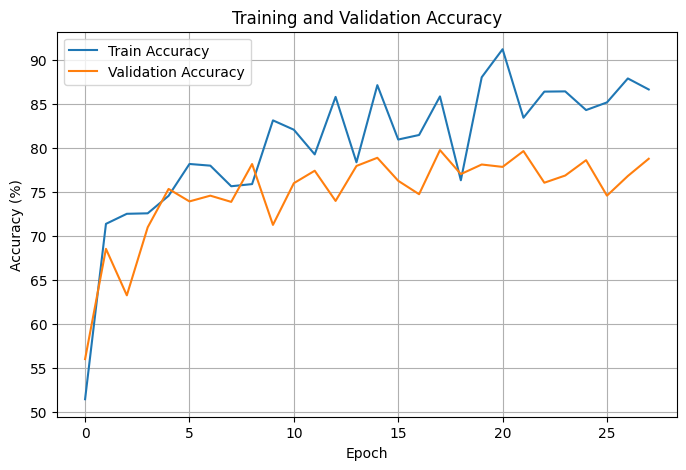

In [9]:
plt.figure(figsize=(8,5))
plt.plot([x*100 for x in history['train_acc']], label="Train Accuracy")
plt.plot([x*100 for x in history['val_acc']], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

### Considerations
We observed that applying Mixup and CutMix throughout the entire training process introduced excessive variability and instability.
This prevented the model from fully consolidating its learning on the true data distribution. As a result, we decided to limit the use of Mixup and CutMix to only the first 15 epochs. In this way, the model benefits from strong regularization and increased robustness during the early stages, while retaining the ability to fine-tune its parameters on clean, unaltered data in the later stages.

In [7]:
def run_epoch_v3(
    model,
    loader,
    opt=None,
    mixup_cutmix_alpha=1.0,
    mixup_cutmix_prob=0.3,
    use_mixup_cutmix=True
):
    model.train(opt is not None)
    total_loss, total_acc = 0, 0

    for x,y in loader:
        x,y = x.to(device), y.to(device)

        if opt and use_mixup_cutmix and np.random.rand() < mixup_cutmix_prob:
            if np.random.rand() < 0.5:
                x_mix, y_a, y_b, lam = mixup_data(x, y, alpha=mixup_cutmix_alpha)
            else:
                x_mix, y_a, y_b, lam = cutmix_data(x, y, alpha=mixup_cutmix_alpha)
            logits = model(x_mix)
            loss = lam * F.cross_entropy(logits, y_a, label_smoothing=0.1) + \
                   (1 - lam) * F.cross_entropy(logits, y_b, label_smoothing=0.1)
        else:
            logits = model(x)
            loss = F.cross_entropy(logits, y, label_smoothing=0.1)

        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item() * x.size(0)
        total_acc  += (logits.argmax(1) == y).float().sum().item()
    return total_loss/len(loader.dataset), total_acc/len(loader.dataset)

def fit_v3(model, epochs=50, lr=1e-3, weight_decay=5e-4, patience=15, mixup_cutmix_epochs=15):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs*2, eta_min=1e-6)

    best_val, best_state = 0, None
    history = {'train_acc':[], 'val_acc':[]}
    wait = 0

    for ep in range(1, epochs+1):
        # solo prime mixup_cutmix_epochs epoche con mixup/cutmix
        use_mixup_cutmix = (ep <= mixup_cutmix_epochs)

        train_loss, train_acc = run_epoch_v3(
            model, train_loader, opt,
            mixup_cutmix_alpha=1.0,
            mixup_cutmix_prob=0.3,
            use_mixup_cutmix=use_mixup_cutmix
        )
        val_loss, val_acc = run_epoch_v3(model, val_loader, use_mixup_cutmix=False)
        scheduler.step()

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if val_acc > best_val:
            best_val, best_state = val_acc, model.state_dict()
            wait = 0
        else:
            wait += 1

        print(f"Ep{ep:02d} − train {train_acc*100:.1f}% | val {val_acc*100:.1f}% | lr={opt.param_groups[0]['lr']:.2e}")

        if wait >= patience:
            print(f"\n→ Early stopping attivato dopo {ep} epoche (no miglioramento su val acc per {patience})")
            break

    model.load_state_dict(best_state)
    _, test_acc = run_epoch_v3(model, test_loader, use_mixup_cutmix=False)
    print(f"\n→ TEST ACCURACY finale: {test_acc*100:.1f}%")

    return history, test_acc


In [8]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

history, test_acc = fit_v3(model, epochs=50, lr=5e-4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Ep01 − train 52.5% | val 61.0% | lr=5.00e-04
Ep02 − train 70.7% | val 73.7% | lr=5.00e-04
Ep03 − train 75.0% | val 56.2% | lr=4.99e-04
Ep04 − train 73.5% | val 72.3% | lr=4.98e-04
Ep05 − train 76.8% | val 69.4% | lr=4.97e-04
Ep06 − train 79.9% | val 68.1% | lr=4.96e-04
Ep07 − train 76.4% | val 71.5% | lr=4.94e-04
Ep08 − train 73.3% | val 75.6% | lr=4.92e-04
Ep09 − train 79.8% | val 74.7% | lr=4.90e-04
Ep10 − train 84.9% | val 73.7% | lr=4.88e-04
Ep11 − train 85.1% | val 76.2% | lr=4.85e-04
Ep12 − train 85.5% | val 75.4% | lr=4.82e-04
Ep13 − train 82.4% | val 78.5% | lr=4.79e-04
Ep14 − train 81.8% | val 76.6% | lr=4.76e-04
Ep15 − train 86.4% | val 76.5% | lr=4.73e-04
Ep16 − train 96.8% | val 76.2% | lr=4.69e-04
Ep17 − train 97.5% | val 79.3% | lr=4.65e-04
Ep18 − train 97.6% | val 78.6% | lr=4.61e-04
Ep19 − train 98.0% | val 79.0% | lr=4.57e-04
Ep20 − train 98.0% | val 79.2% | lr=4.52e-04
Ep21 − train 97.7% | val 80.5% | lr=4.48e-04
Ep22 − train 98.0% | val 79.3% | lr=4.43e-04
Ep23 − tra

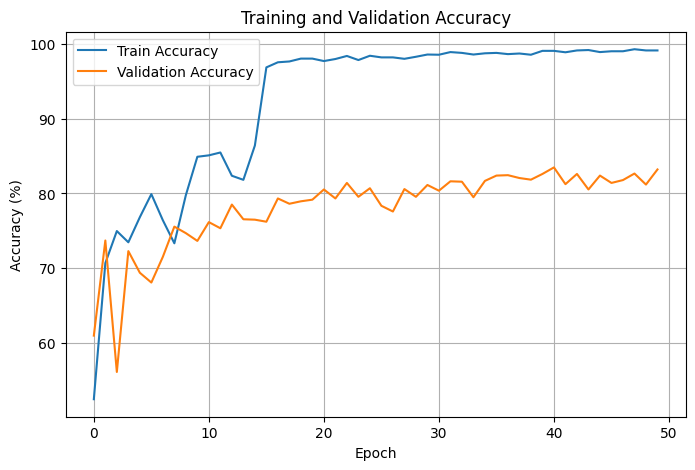

In [9]:
plt.figure(figsize=(8,5))
plt.plot([x*100 for x in history['train_acc']], label="Train Accuracy")
plt.plot([x*100 for x in history['val_acc']], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

### Considerations

Applying Mixup and CutMix during the early stages of training produce a small but noticeable improvement. By limiting their use to the first 15 epochs, we balanced regularization and convergence, ultimately achieving a 3% increase in test accuracy compared to the baseline.

Despite this improvement, a performance gap of approximately 15% still remains between training and validation accuracy, indicating potential overfitting and suggesting that further refinement—such as stronger regularization, better model calibration, or ensembling—may be needed to close the generalization gap.
